In [43]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate
import datetime
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix


Wgranie plików - zbiór treningowy

In [44]:
pict_train = tf.keras.utils.image_dataset_from_directory(
    'images_labeled/images labeled/',
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=123,
    batch_size=32,
    image_size=(224,224)

)

Found 3717 files belonging to 2 classes.
Using 2974 files for training.


Wgranie plików - zbiór walidacyjny

In [45]:
pict_val = tf.keras.utils.image_dataset_from_directory(
    'images_labeled/images labeled/',
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=123,
    batch_size=32,
    image_size=(224,224)
)

Found 3717 files belonging to 2 classes.
Using 743 files for validation.


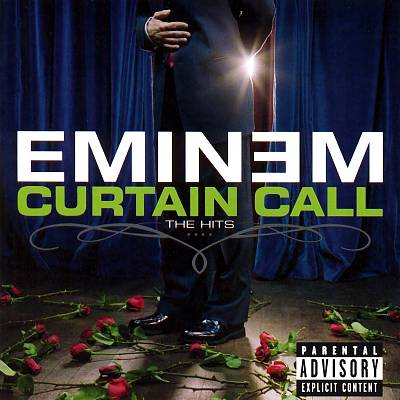

In [4]:
tf.keras.utils.load_img('images_labeled/images labeled/rap/0_6.jpg')

2023-06-18 12:10:00.035226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2974]
	 [[{{node Placeholder/_4}}]]
2023-06-18 12:10:00.036099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2974]
	 [[{{node Placeholder/_0}}]]


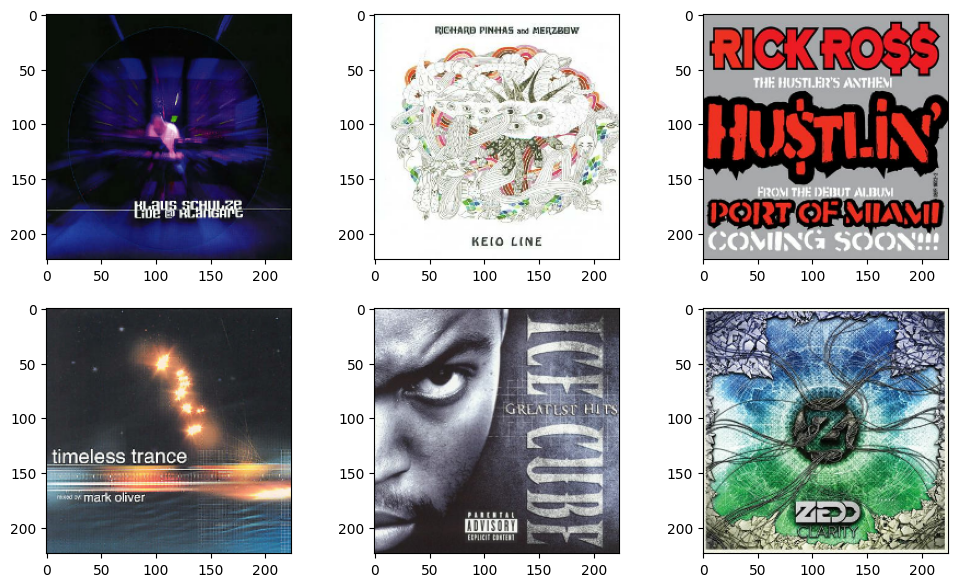

In [5]:
class_names = pict_train.class_names

plt.figure(figsize=(12,7))
for images, labels in pict_train.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        #plt.title(class_names[labels[i]])


In [46]:
class_names

['electro', 'rap']

In [23]:
for batch_x, batch_y in pict_train.take(1):
    print(batch_x.shape)
    print(batch_y.shape)

2023-06-18 12:26:01.278043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2974]
	 [[{{node Placeholder/_4}}]]
2023-06-18 12:26:01.278897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2974]
	 [[{{node Placeholder/_4}}]]


(32, 224, 224, 3)
(32, 2)


In [62]:
#norm_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)

#norm_train = pict_train.map(lambda x, y: (norm_layer(x), y))
#norm_val = pict_val.map(lambda x, y: (norm_layer(x), y))

Podział na zbiór treningowy i testowy

In [8]:
#train, test = tf.keras.utils.split_dataset(pict_train, left_size=0.8, shuffle=True, seed=123)

2023-06-18 12:10:19.372537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2974]
	 [[{{node Placeholder/_4}}]]
2023-06-18 12:10:19.373079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2974]
	 [[{{node Placeholder/_0}}]]


Normalizacja obrazków do jakiegoś rozmiaru

In [24]:
norm_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)

norm_train = pict_train.map(lambda x, y: (norm_layer(x), y))
norm_val = pict_val.map(lambda x, y: (norm_layer(x), y))
#norm_test = test.map(lambda x, y: (norm_layer(x), y))

In [12]:
from tensorflow import keras

Skopiowałam resnet z lekcji i zmodyfikowałam shape (nie wiem czy dobrze i czy nie trzeba zmienić funkcji aktywacji)

In [47]:
# definicja bloku resnet
def res_block(input, filters):
    x_1 = keras.layers.Conv2D(filters=filters, kernel_size = (3,3), padding = 'same')(input)
    x_1 = keras.layers.BatchNormalization()(x_1)
    x_1 = keras.layers.ReLU()(x_1)

    x_2 = keras.layers.Conv2D(filters=filters, kernel_size = (3,3), padding = 'same')(x_1)
    x_2 = keras.layers.BatchNormalization()(x_2)

    output = keras.layers.Add()([input, x_2])
    output = keras.layers.ReLU()(output)

    return output

# prezentacja bloku resnet
input = keras.layers.Input(shape = (224,224,3))
dummy_res_block_model = keras.models.Model(inputs = input, outputs = res_block(input, 3))
dummy_res_block_model.summary()
keras.utils.plot_model(dummy_res_block_model, show_shapes=True)

# definicja bloku resnet
def res_block_downsample(input, filters):
    x_1 = keras.layers.Conv2D(filters=filters, kernel_size = (3,3), strides=(2,2), padding = 'same')(input)
    x_1 = keras.layers.BatchNormalization()(x_1)
    x_1 = keras.layers.ReLU()(x_1)

    x_2 = keras.layers.Conv2D(filters=filters, kernel_size = (3,3), padding = 'same')(x_1)
    x_2 = keras.layers.BatchNormalization()(x_2)

    input_downsample = keras.layers.Conv2D(filters=filters, kernel_size = (1,1), strides=(2,2) ,padding = 'same')(input)
    
    output = keras.layers.Add()([input_downsample, x_2])
    output = keras.layers.ReLU()(output)

    return output

# prezentacja bloku resnet downsample
input = keras.layers.Input(shape = (224,224,3))
dummy_res_block_downsample_model = keras.models.Model(inputs = input, outputs = res_block_downsample(input, 3))
dummy_res_block_downsample_model.summary()
keras.utils.plot_model(dummy_res_block_downsample_model, show_shapes=True)



input_layer = keras.Input(shape=(224, 224, 3), dtype = tf.float32)

bn_0 = keras.layers.BatchNormalization()(input_layer)
conv_0 = keras.layers.Conv2D(filters=8, kernel_size = (3,3), strides=(1,1), padding = 'same')(bn_0)
relu = keras.layers.ReLU()(conv_0)
bn_1 = keras.layers.BatchNormalization()(relu)

resblock_1 = res_block(bn_1, 8)
resblock_2 = res_block(resblock_1, 8)
resblock_3 = res_block(resblock_2, 8)
resblock_4 = res_block_downsample(resblock_3, 16)

resblock_5 = res_block(resblock_4, 16)
resblock_6 = res_block(resblock_5, 16)
resblock_7 = res_block(resblock_6, 16)
resblock_8 = res_block_downsample(resblock_7, 32)

resblock_9 = res_block(resblock_8, 32)
resblock_10 = res_block(resblock_9, 32)
resblock_11 = res_block(resblock_10, 32)
resblock_12 = res_block_downsample(resblock_11, 64)

avg_pool = keras.layers.GlobalAveragePooling2D()(resblock_12)
#flat = keras.layers.Flatten()(resblock_12)
dropout = keras.layers.Dropout(0.7)(avg_pool)
out = keras.layers.Dense(2)(dropout)
out = keras.layers.Softmax()(out)

model_small_resnet = tf.keras.Model(
    inputs=input_layer,
    outputs=out,
    name="small_resnet"
)

model_small_resnet.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_66 (Conv2D)             (None, 224, 224, 3)  84          ['input_9[0][0]']                
                                                                                                  
 batch_normalization_60 (BatchN  (None, 224, 224, 3)  12         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                            

Kompilacja, zmieniłam funkcję straty na Binary Crossentropy

In [48]:
model_small_resnet.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"],
)

In [49]:
model_small_resnet.fit(
    norm_train,
    #validation_data=norm_val,
    epochs=50
)

Epoch 1/50
93/93 [==============================] - 487s 5s/step - loss: 0.8858 - accuracy: 0.5464
Epoch 2/50
93/93 [==============================] - 422s 5s/step - loss: 0.6966 - accuracy: 0.5730
Epoch 3/50
93/93 [==============================] - 404s 4s/step - loss: 0.6909 - accuracy: 0.5686
Epoch 4/50
93/93 [==============================] - 401s 4s/step - loss: 0.6763 - accuracy: 0.5861
Epoch 5/50
93/93 [==============================] - 387s 4s/step - loss: 0.6748 - accuracy: 0.6015
Epoch 6/50
93/93 [==============================] - 388s 4s/step - loss: 0.6674 - accuracy: 0.6197
Epoch 7/50
93/93 [==============================] - 408s 4s/step - loss: 0.6626 - accuracy: 0.6059
Epoch 8/50
93/93 [==============================] - 418s 4s/step - loss: 0.6538 - accuracy: 0.6321
Epoch 9/50
93/93 [==============================] - 402s 4s/step - loss: 0.6450 - accuracy: 0.6446
Epoch 10/50
93/93 [==============================] - 400s 4s/step - loss: 0.6103 - accuracy: 0.6927
Epoch 11/

Spróbowałam zaimplementować tutaj ten transfer learning

In [34]:
input_shape = (224, 224, 3)

In [35]:
inputLayer = tf.keras.Input(shape=(input_shape))

In [36]:
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',  # wczytaj z nauczonymi wagami
    input_shape=input_shape,
    include_top=False)   # nie dołączaj ostatniej warstwy klasyfikatora, sami swoją dodamy

In [37]:
base_model.trainable = False

In [38]:
x = base_model(inputLayer, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(1)(x)

In [39]:
model = tf.keras.Model(inputLayer, output)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainab

In [40]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"],
)

Niestety accuracy w ogóle nie rośnie, podejrzewam, że coś trzeba zmienić w samej sieci

In [41]:
history = model.fit(
    norm_train,
    epochs=50,
    #validation_data=norm_val
)
    
    

Epoch 1/50
93/93 [==============================] - 82s 711ms/step - loss: 6.4660 - accuracy: 0.5000
Epoch 2/50
33/93 [=========>....................] - ETA: 42s - loss: 7.5430 - accuracy: 0.5000

KeyboardInterrupt: 